Use `sybil2` as the conda environment. 

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pandas as pd

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [196]:
def load_data(dir_name, file_prefix, type_):
    all_paths = [path for path in os.listdir(dir_name) if path.startswith(file_prefix) and path.endswith(".json")]

    print(f"Processing {len(all_paths)} paths...")

    if type_ == "list":
        out = []
    elif type_ == "dict":
        out = {}

    for path in all_paths:
        with open(os.path.join(dir_name, path), 'r') as f:
            path_data = json.load(f)

            if type_ == "list":
                assert isinstance(path_data, list)
                out += path_data
            elif type_ == "dict":
                assert isinstance(path_data, dict)
                out |= path_data

    return out

In [197]:
def compute_annotation_stats(data):
    total_patients_with_annotations = 0
    total_scans_with_annotations = 0

    for patient_id, patient_data in data.items():
        bboxes = patient_data.get("bboxes", {})
        t0_has_bboxes = bboxes.get("T0_has_bboxes", False)
        t1_has_bboxes = bboxes.get("T1_has_bboxes", False)
        t2_has_bboxes = bboxes.get("T2_has_bboxes", False)
        
        if t0_has_bboxes or t1_has_bboxes or t2_has_bboxes:
            total_patients_with_annotations += 1
        
        total_scans_with_annotations += int(t0_has_bboxes) + int(t1_has_bboxes) + int(t2_has_bboxes)

    return total_patients_with_annotations, total_scans_with_annotations

In [198]:
def compute_basic_statistics(data, should_prune_t0=False):
    num_patients = len(data)
    scan_counts = [len(patient_data['total_num_nodules']) for patient_data in data.values()]
    
    num_scans = sum(scan_counts)
    num_patients_1_scan = sum(1 for c in scan_counts if c == 1)
    num_patients_2_scan = sum(1 for c in scan_counts if c == 2)
    num_patients_3_scan = sum(1 for c in scan_counts if c == 3)
    
    total_predicted_nodules = sum(
        sum(patient_data['total_num_nodules'].values()) for patient_data in data.values()
    )
    
    unmatched_nodules = sum(len(patient_data.get("unmatched_nodules", {})) for patient_data in data.values())
    matched_nodules_count = defaultdict(int)
    
    for patient_data in data.values():
        for nodule_id, timepoints in patient_data.get("matched_nodules", {}).items():
            assert len(timepoints) in {1, 2, 3}
            matched_nodules_count[len(timepoints)] += 1
    
    matched_nodules_2 = matched_nodules_count[2]
    matched_nodules_3 = matched_nodules_count[3]
    
    if not should_prune_t0:
        assert total_predicted_nodules == unmatched_nodules + 2 * matched_nodules_2 + 3 * matched_nodules_3

    num_patients_with_annotations, num_scans_with_annotations = compute_annotation_stats(data)
    
    return {
        "num_patients": num_patients,
        "num_patients_1_scan": num_patients_1_scan,
        "num_patients_2_scan": num_patients_2_scan,
        "num_patients_3_scan": num_patients_3_scan,
        "num_scans": num_scans,
        "total_predicted_nodules": total_predicted_nodules,
        "unmatched_nodules": unmatched_nodules,
        "matched_nodules_2": matched_nodules_2,
        "matched_nodules_3": matched_nodules_3,
        "num_patients_with_annotations": num_patients_with_annotations,
        "num_scans_with_annotations": num_scans_with_annotations,
    }

In [199]:
def compute_distributions(data, should_prune_t0=False):
    nodules_per_scan = []
    nodules_per_patient = []
    all_volumes = []
    matched_volumes = []
    
    for patient_id, patient_data in data.items():
        nodules_per_patient.append(sum(patient_data['total_num_nodules'].values()))
        
        for timepoint, count in patient_data['total_num_nodules'].items():
            nodules_per_scan.append(count)
        
        # matched
        for nodule in patient_data.get("matched_nodules", {}).values():
            for timepoint_data in nodule.values():
                all_volumes.append(timepoint_data["mask_volume"])
                matched_volumes.append(timepoint_data["mask_volume"])
        
        # unmatched
        for nodule in patient_data.get("unmatched_nodules", {}).values():
            all_volumes.append(nodule["mask_volume"])

    if not should_prune_t0:
        assert len(all_volumes) == sum(nodules_per_scan) and len(all_volumes) == sum(nodules_per_patient)
                
    return nodules_per_scan, nodules_per_patient, all_volumes, matched_volumes

In [200]:
def plot_distribution(data, title, xlabel, ylabel, with_mean=True, xlim=None):
    num_bins = 30
    size = 12
    plt.hist(data, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5)
    plt.title(f"{title} (N = {len(data)})", size=size)

    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data)
    
    if with_mean:
        text_str = f"Mean: {mean_val:.2f}\nMedian: {median_val:.2f}"
    else:
        text_str = f"Median: {median_val:.2f}"
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.xlabel(xlabel, size=size)
    plt.ylabel(ylabel, size=size)
    plt.show()

In [201]:
def plot_distribution_overlay(data1, data2, title, xlabel, ylabel, label1, label2, xlim=None):
    num_bins = 30
    size = 20
    plt.hist(data1, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5, color="blue", label=label1)
    plt.hist(data2, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5, color="red", label=label2)
    plt.title(f"{title} (N of {label1} = {len(data1)}, N of {label2} = {len(data2)})", size=size)

    # text_str = f"Median ({label1}): {np.median(data1):.2f}\nMedian ({label2}): {np.median(data2):.2f}"
    text_str = f"Median ({label1}): {np.median(data1):.2f}\nMedian ({label2}): {np.median(data2):.2f}\nMean ({label1}): {np.mean(data1):.2f}\nMean ({label2}): {np.mean(data2):.2f}"
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.xlabel(xlabel, size=size)
    plt.ylabel(ylabel, size=size)
    plt.legend()
    plt.show()

In [202]:
def prune_t0(data):
    out = {}

    for pid, pid_entry in data.items():
        out[pid] = {}
        out[pid]['matched_nodules'] = {
            k: v for k, v in pid_entry['matched_nodules'].items() if v.get('timepoint') != 'T0'
        }
        out[pid]['unmatched_nodules'] = {
            k: v for k, v in pid_entry['unmatched_nodules'].items() if v.get('timepoint') != 'T0'
        }
        out[pid]['bboxes'] = {k: v for k, v in pid_entry['bboxes'].items() if 'T0' not in k}
        out[pid]['reg_metrics'] = {k: v for k, v in pid_entry['reg_metrics'].items() if 'T0' not in k}

        out[pid]['total_num_voxels'] = {k: v for k, v in pid_entry['total_num_voxels'].items() if 'T0' not in k}
        out[pid]['total_num_nodules'] = {k: v for k, v in pid_entry['total_num_nodules'].items() if 'T0' not in k}

        if "T0" in pid_entry['total_num_voxels']:
            out[pid]['num_scans'] = pid_entry["num_scans"] - 1
        else:
            out[pid]['num_scans'] = pid_entry["num_scans"]

    return out
    

In [203]:
# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_1"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_1_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_2"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_2_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_3"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_3_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/tsm_25dfb675_nn_all_mask_min_1_no_mask"
# file_prefix = "matching_outputs_tsm_25dfb675_nn_all_mask_min_1_no_mask_mcs_25_new_group"

is_cancer = True

if is_cancer:
    dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/tsm_25dfb675"
    file_prefix = "matching_outputs_tsm_25dfb675_mcs_25_new_group"
    metadata = pd.read_csv("/data/rbg/users/pgmikhael/current/SybilX/notebooks/NoduleGrowth/nlst_cancer_nodules.csv")
else:
    dir_name = "/data/rbg/scratch/nlst_benign_nodules/v2/matching/tsm_25dfb675"
    file_prefix = "matching_outputs_tsm_25dfb675_mcs_25_new_group"
    metadata = pd.read_csv("/data/rbg/users/pgmikhael/current/SybilX/notebooks/NoduleGrowth/nlst_benign_nodules.csv")

data = load_data(dir_name, file_prefix, "dict")

data = {k:v for k,v in data.items() if not (k == "116970" and not is_cancer)} # corrupted output

should_prune_t0 = False

if should_prune_t0:
    data = prune_t0(data)

skipped = load_data(dir_name, file_prefix.replace("outputs", "skipped"), "list")

stats = compute_basic_statistics(data, should_prune_t0)


Processing 10 paths...
Processing 10 paths...


In [204]:
# number of skipped is an undercount for BMP2D_FINETUNED
print("Basic Statistics:\n\n")
print(f"num_skipped_patients: {len(skipped)}")
for key, value in stats.items():
    print(f"{key}: {value}")

Basic Statistics:


num_skipped_patients: 52
num_patients: 737
num_patients_1_scan: 268
num_patients_2_scan: 179
num_patients_3_scan: 290
num_scans: 1496
total_predicted_nodules: 5610
unmatched_nodules: 4297
matched_nodules_2: 457
matched_nodules_3: 133
num_patients_with_annotations: 498
num_scans_with_annotations: 815


In [205]:
# data['118121']

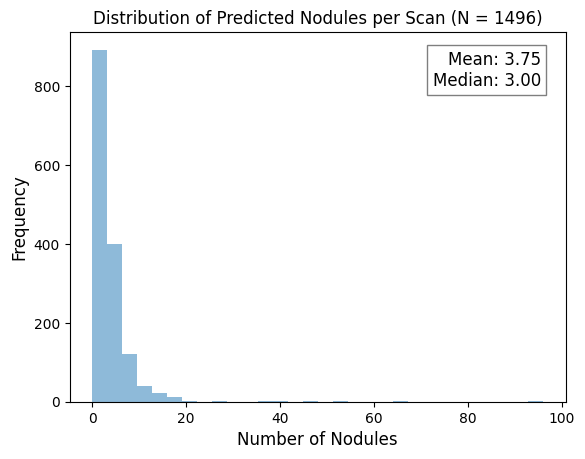

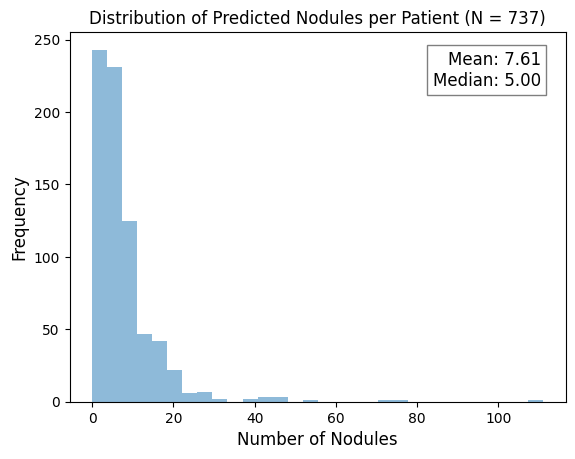

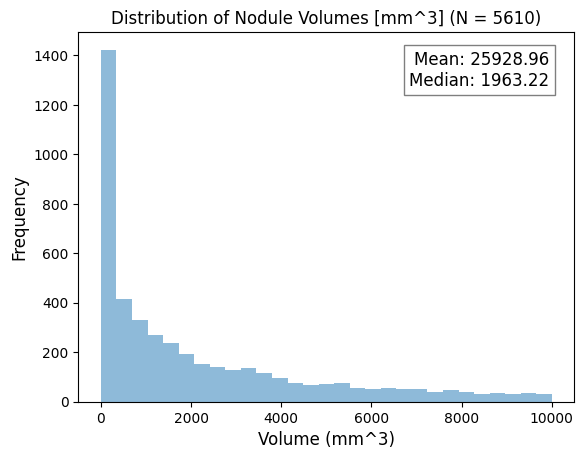

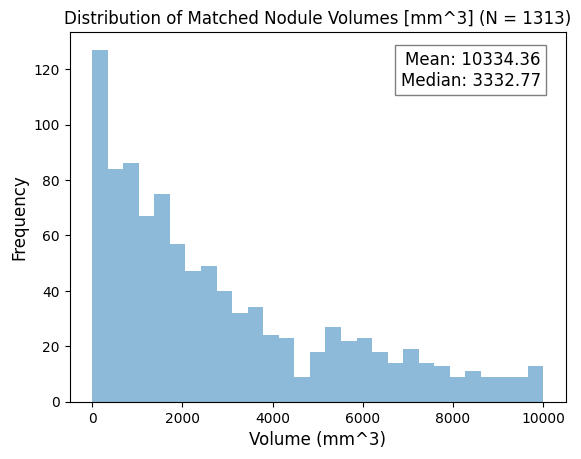

In [206]:
nodules_per_scan, nodules_per_patient, all_volumes, matched_volumes = compute_distributions(data, should_prune_t0)

# plot_distribution(nodules_per_scan, "Distribution of Predicted Nodules per Scan\n", "Number of Nodules", "Frequency")
plot_distribution(nodules_per_scan, "Distribution of Predicted Nodules per Scan", "Number of Nodules", "Frequency")
plot_distribution(nodules_per_patient, "Distribution of Predicted Nodules per Patient", "Number of Nodules", "Frequency")
plot_distribution(all_volumes, "Distribution of Nodule Volumes [mm^3]", "Volume (mm^3)", "Frequency", xlim=(0, 10000))
# plot_distribution(all_volumes, "Distribution of Nodule Volumes (mm^3)", "Volume (mm^3)", "Frequency")
plot_distribution(matched_volumes, "Distribution of Matched Nodule Volumes [mm^3]", "Volume (mm^3)", "Frequency", xlim=(0, 10000))

## Growth

In [207]:
metadata.columns

Index(['PID', 'IsSmallCell', 'CancerTP', 'NumExams', 'Days2Cancer_0',
       'DaysSinceRand_0', 'Annotated_0', 'Days2FUP_0', 'Series_0',
       'abnormalities_0', 'attentuations_0', 'longest_diameter_0',
       'perp_diameter_0', 'growth_0', 'change_0', 'exists_0', 'slice_number_0',
       'age_0', 'years_since_quit_smoking_0', 'Days2Cancer_1',
       'DaysSinceRand_1', 'Annotated_1', 'Days2FUP_1', 'Series_1',
       'abnormalities_1', 'attentuations_1', 'longest_diameter_1',
       'perp_diameter_1', 'growth_1', 'change_1', 'exists_1', 'slice_number_1',
       'age_1', 'years_since_quit_smoking_1', 'Days2Cancer_2',
       'DaysSinceRand_2', 'Annotated_2', 'Days2FUP_2', 'Series_2',
       'abnormalities_2', 'attentuations_2', 'longest_diameter_2',
       'perp_diameter_2', 'growth_2', 'change_2', 'exists_2', 'slice_number_2',
       'age_2', 'years_since_quit_smoking_2', 'age_start_smoking',
       'age_quit_smoking', 'years_smoking', 'is_smoker', 'family_hx'],
      dtype='object')

In [208]:
def volume_percentage_change(v0, v1):
    return ((v1 - v0) / v0) * 100 if v0 > 0 else np.nan

def volume_doubling_time(v0, v1, time_diff):
    if v0 > 0 and v1 > v0 and time_diff > 0:
        return (np.log(2) / np.log(v1 / v0)) * time_diff
    return np.nan

In [209]:
metadata[["DaysSinceRand_1", "DaysSinceRand_0"]]

,DaysSinceRand_1,DaysSinceRand_0
0,NaN,57.0
1,345.0,23.0
2,349.0,NaN
3,515.0,0.0
4,NaN,22.0
...,...,...
820,NaN,39.0
821,392.0,0.0
822,NaN,23.0
823,381.0,0.0


In [210]:
def compute_growth_statistics(data, df):
    growth_data = []
    unmatched_earlier = {"NSCLC": 0, "SCLC": 0, "benign": 0}
    unmatched_later = {"NSCLC": 0, "SCLC": 0, "benign": 0}
    early_detection = {"NSCLC": 0, "SCLC": 0, "benign": 0}

    for pid in data:
        patient_data = data[pid]
        if is_cancer:
            cancer_type = "NSCLC" if df.loc[df["PID"] == int(pid), "IsSmallCell"].values[0] == 0 else "SCLC"
        else:
            cancer_type = "benign"

        matched_nodules = patient_data["matched_nodules"]
        for nodule_entry in matched_nodules.values():
            # skip T0 and T2 pairs (we want one-timepoint changes)
            if "T0" in nodule_entry and "T1" in nodule_entry:
                T0, T1 = nodule_entry["T0"], nodule_entry["T1"]
                v0, v1 = T0["mask_volume"], T1["mask_volume"]

                time_diff = df.loc[df["PID"] == int(pid), "DaysSinceRand_1"].values[0] - df.loc[df["PID"] == int(pid), "DaysSinceRand_0"].values[0]
                    
                growth_data.append({
                    "PID": pid,
                    "volume_change": volume_percentage_change(v0, v1),
                    "doubling_time": volume_doubling_time(v0, v1, time_diff),
                    "cancer_type": cancer_type,
                    "first": "T0",
                    "second": "T1",
                })

            if "T1" in nodule_entry and "T2" in nodule_entry:
                T1, T2 = nodule_entry["T1"], nodule_entry["T2"]
                v1, v2 = T1["mask_volume"], T2["mask_volume"]

                time_diff = df.loc[df["PID"] == int(pid), "DaysSinceRand_2"].values[0] - df.loc[df["PID"] == int(pid), "DaysSinceRand_1"].values[0]
                    
                growth_data.append({
                    "PID": pid,
                    "volume_change": volume_percentage_change(v1, v2),
                    "doubling_time": volume_doubling_time(v1, v2, time_diff),
                    "cancer_type": cancer_type,
                    "first": "T1",
                    "second": "T2",
                })
        
        # Unmatched nodules appearing earlier or later
        unmatched_nodules = patient_data["unmatched_nodules"]
        for nodule in unmatched_nodules.values():
            timepoint = nodule["timepoint"]
            if timepoint == "T2":
                if patient_data["total_num_nodules"].get("T0", 0) > 0 or patient_data["total_num_nodules"].get("T1", 0) > 0:
                    unmatched_earlier[cancer_type] += 1
            elif timepoint == "T1":
                if patient_data["total_num_nodules"].get("T0", 0) > 0:
                    unmatched_earlier[cancer_type] += 1
                if patient_data["total_num_nodules"].get("T2", 0) > 0:
                    unmatched_later[cancer_type] += 1
            elif timepoint == "T0":
                if patient_data["total_num_nodules"].get("T1", 0) > 0 or patient_data["total_num_nodules"].get("T2", 0) > 0:
                    unmatched_later[cancer_type] += 1
        
        
        
        # # Matched nodules with an earlier scan
        # previous_scans = df.loc[df["PID"] == int(pid), "Series_0"].values
        # if len(previous_scans) > 1:
        #     matched_earlier_scan["total"] += 1
        #     if np.isnan(df.loc[df["PID"] == int(pid), "longest_diameter_0"].values[0]):
        #         matched_earlier_scan["no_diameter"] += 1

    growth_df = pd.DataFrame(growth_data)

    # # Output results
    # print("Growth Analysis:")
    # # print(growth_df.groupby("cancer_type")["volume_change", "doubling_time"].describe())

    # print("\nUnmatched nodules appearing earlier:", unmatched_earlier)
    # print("Unmatched nodules appearing later:", unmatched_later)
    # # print("\nMatched nodules with an earlier scan:", matched_earlier_scan)

    return growth_df, unmatched_earlier, unmatched_later, early_detection


In [211]:
growth_df, unmatched_earlier, unmatched_later, early_detection = compute_growth_statistics(data, metadata)

In [212]:
growth_df[growth_df["PID"] == "126967"]

,PID,volume_change,doubling_time,cancer_type,first,second


In [213]:
cols = [col for col in metadata.columns if "_0" in col]

In [214]:
annotations = json.load(open("/data/rbg/shared/datasets/NLST/NLST/annotations_122020.json", "r"))

In [215]:
annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"]

{'1.2.840.113654.2.55.163157187122431509690781522115404072036': [{'x': 0.57159541015625,
   'y': 0.58550396484375,
   'width': 0.0838051953125,
   'height': 0.07701021484375,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.253307140210856805054979155186064149226': [{'x': 0.56593287109375,
   'y': 0.58323896484375,
   'width': 0.09060025390625,
   'height': 0.0792751953125,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.58364372794881369367486462306831359202': [{'x': 0.5703125,
   'y': 0.583984375,
   'width': 0.0859375,
   'height': 0.078125,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.106110028426812472195508696323718613319': [{'x': 0.568359375,
   'y': 0.583984375,
   'width': 0.087890625,
   'height': 0.078125,
   'user': 'pbourgouin@bwh.harvard.edu'}]}

In [216]:
import torch
import math
import numpy as np
slice_ids = list(annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"].keys())
mask = torch.zeros((197, 512, 512))
W, H = mask.shape[1:]
for i, slice in enumerate(slice_ids):
    for bbox in annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"].get(slice, []):
        x_left, y_top = bbox["x"] * W, bbox["y"] * H
        x_right, y_bottom = x_left + bbox["width"] * W, y_top + bbox["height"] * H
        x_left, y_top = math.floor(x_left), math.floor(y_top)
        x_right, y_bottom = math.ceil(x_right), math.ceil(y_bottom)
        mask[i,y_top:y_bottom, x_left:x_right] = 1
        print(x_left)

292
289
292
291


In [217]:
np.count_nonzero(mask)

7380

In [218]:
growth_df[growth_df["volume_change"] < 0].describe()

,volume_change,doubling_time
count,298.000000,0.0
mean,-50.033434,NaN
std,29.258319,NaN
min,-99.817369,NaN
25%,-75.214095,NaN
50%,-49.703950,NaN
75%,-25.632088,NaN
max,-0.162419,NaN


In [219]:
# days_to_cancer_from_earliest_matched_scan = get_days_to_cancer_from_earliest_matched_scan(data, metadata)
# days_to_cancer_from_last_scan = get_days_to_cancer_from_last_scan(data, metadata)

In [220]:
# plot_distribution(days_to_cancer_from_earliest_matched_scan, "Days to Cancer from Earliest Matched Scan", "Days", "Frequency")
# plot_distribution(days_to_cancer_from_last_scan, "Days to Cancer from Last Scan", "Days", "Frequency")

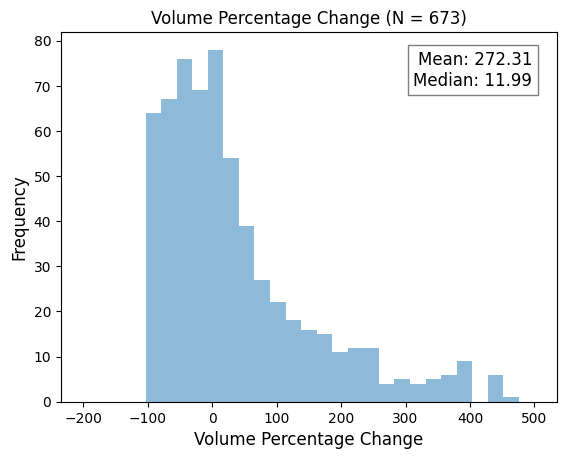

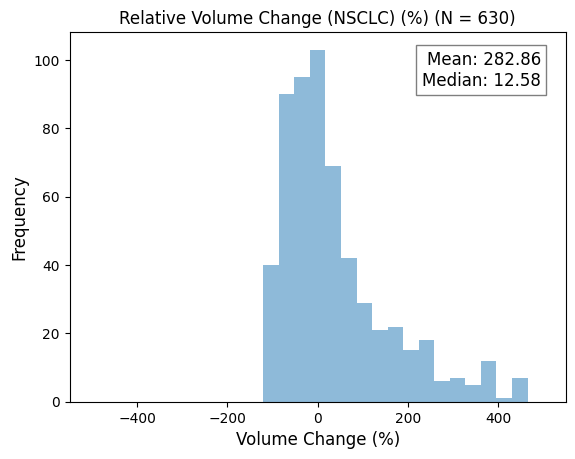

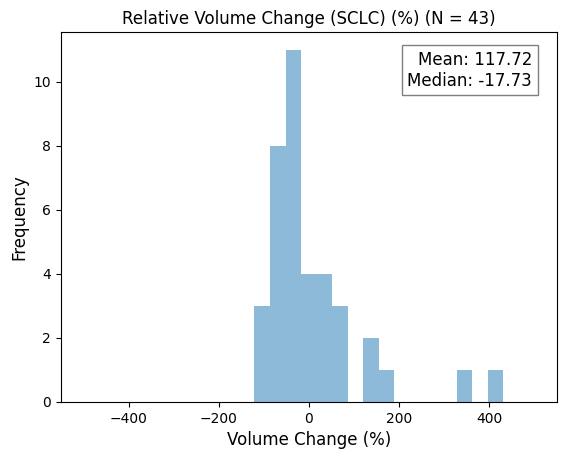

/data/rbg/users/erubel/miniconda3/envs/sybil2/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/rbg/users/erubel/miniconda3/envs/sybil2/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/rbg/users/erubel/miniconda3/envs/sybil2/lib/python3.11/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/rbg/users/erubel/miniconda3/envs/sybil2/lib/python3.11/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/rbg/users/erubel/miniconda3/envs/sybil2/lib/python3.11/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

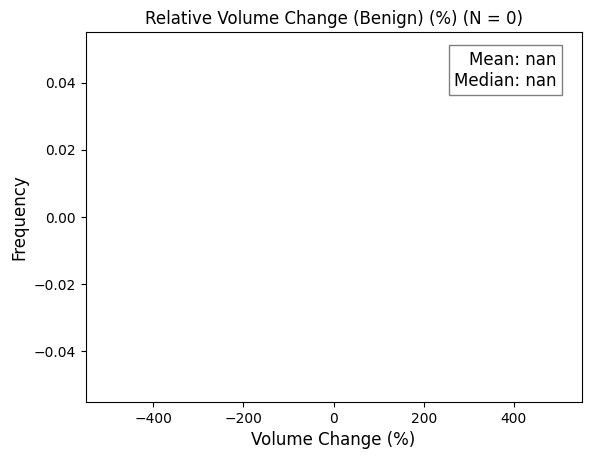

In [221]:
# plot_distribution(growth_df["volume_change"].dropna().tolist(), "Volume Change (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500))
plot_distribution(growth_df["volume_change"].dropna().tolist(), "Volume Percentage Change", "Volume Percentage Change", "Frequency", xlim=(-200, 500))
plot_distribution(growth_df[growth_df["cancer_type"] == "NSCLC"]["volume_change"].dropna().tolist(), "Relative Volume Change (NSCLC) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500))
plot_distribution(growth_df[growth_df["cancer_type"] == "SCLC"]["volume_change"].dropna().tolist(), "Relative Volume Change (SCLC) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500))
plot_distribution(growth_df[growth_df["cancer_type"] == "benign"]["volume_change"].dropna().tolist(), "Relative Volume Change (Benign) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500))

In [254]:
metadata["Days2Cancer_0"]

0        20.0
1      1744.0
2         NaN
3       924.0
4        33.0
        ...  
820      63.0
821     459.0
822    1510.0
823     836.0
824     445.0
Name: Days2Cancer_0, Length: 825, dtype: float64

In [222]:
# of the pairs

# increase_threshold = 25
# decrease_threshold = -25

increase_threshold = 20
decrease_threshold = -10

volume_change_vals = growth_df["volume_change"].dropna().tolist()

print(f"{len([val for val in volume_change_vals if val >= increase_threshold]) / len(volume_change_vals)}% of pairs increase in volume")
print(f"{len([val for val in volume_change_vals if val <= decrease_threshold]) / len(volume_change_vals)}% of pairs decrease in volume")
print(f"{len([val for val in volume_change_vals if val < increase_threshold and val > decrease_threshold]) / len(volume_change_vals)}% of pairs maintain the same volume")

0.46656760772659733% of pairs increase in volume
0.38930163447251115% of pairs decrease in volume
0.14413075780089152% of pairs maintain the same volume


In [223]:
ranges = [(-100, -25), (-25, 25), (25, 50), (50, 100), (100, 200), (200, float("inf"))]

volume_change_val = np.array(growth_df["volume_change"].dropna().tolist())

sum_ = 0
for (start_, stop_) in ranges:
    res = np.mean(np.logical_and(volume_change_val >= start_, volume_change_val < stop_))
    print(start_, stop_, res)

    sum_ += res

-100 -25 0.3328380386329866
-25 25 0.2139673105497771
25 50 0.08172362555720654
50 100 0.09212481426448738
100 200 0.10104011887072809
200 inf 0.17830609212481427


In [224]:
sum_

np.float64(1.0)

In [225]:
growth_df["volume_change"].min()

np.float64(-99.81736896379847)

In [226]:
# plot_binned_dist(growth_df["volume_change"].dropna().tolist(), "Percent Volume Change\n", "Relative Volume Change (%)", "Frequency", xlim=(-200, 500))

In [227]:
growth_df["doubling_time"]

0       259.305620
1       442.490233
2       311.623175
3              NaN
4              NaN
          ...     
668    1517.934831
669            NaN
670     216.942469
671            NaN
672    4227.552666
Name: doubling_time, Length: 673, dtype: float64

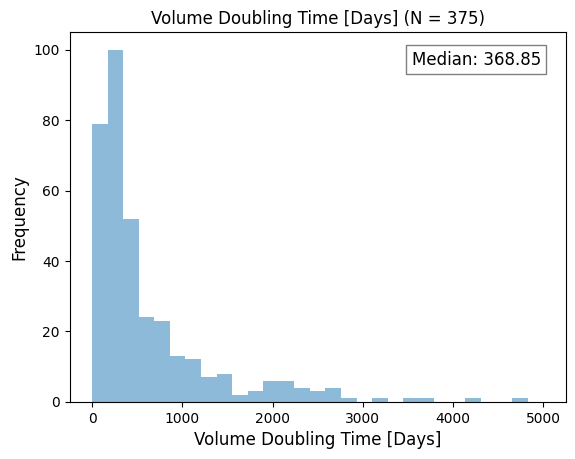

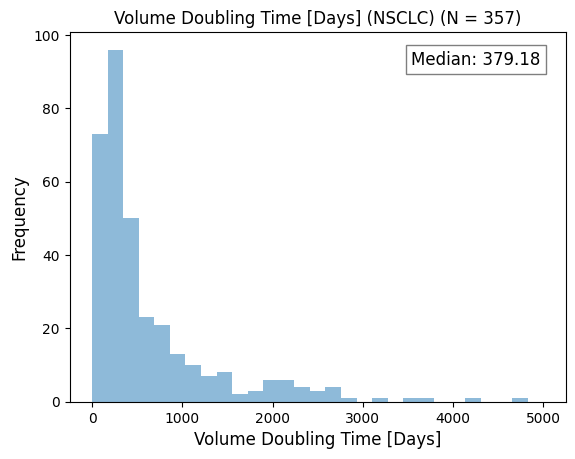

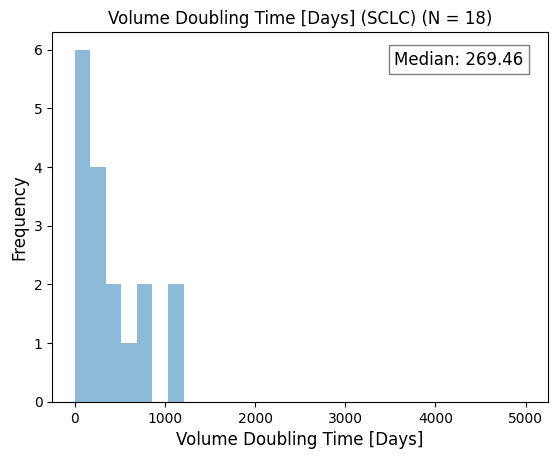

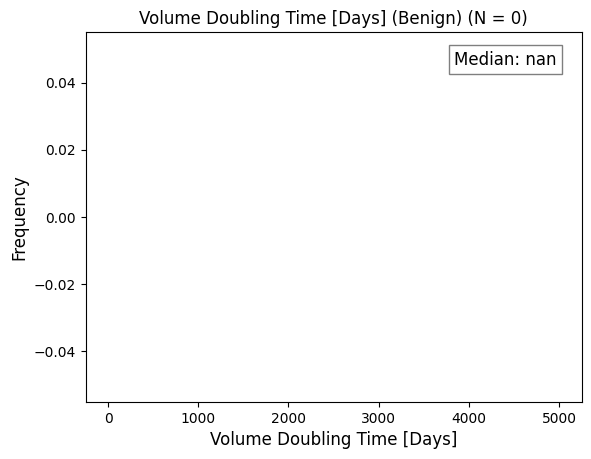

In [228]:
plot_distribution(growth_df["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days]", "Volume Doubling Time [Days]", "Frequency", with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (NSCLC)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (SCLC)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "benign"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (Benign)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))

In [229]:
data_biggest_only = {}

In [230]:
data

{'132628': {'matched_nodules': {},
  'unmatched_nodules': {'0': {'mask_volume': 194.734375,
    'instance_label': 1,
    'has_bbox_overlap': False,
    'mask_slice_range': [150, 151],
    'bbox_slice_range': [],
    'timepoint': 'T0'},
   '1': {'mask_volume': 3284.41162109375,
    'instance_label': 1,
    'has_bbox_overlap': False,
    'mask_slice_range': [103, 104, 105, 106, 107, 108],
    'bbox_slice_range': [],
    'timepoint': 'T2'},
   '2': {'mask_volume': 39147.47009277344,
    'instance_label': 2,
    'has_bbox_overlap': False,
    'mask_slice_range': [44,
     45,
     46,
     47,
     48,
     49,
     50,
     51,
     52,
     53,
     54,
     55,
     56,
     57,
     58,
     59,
     60,
     61,
     62,
     63,
     64,
     65,
     66,
     67,
     68,
     69,
     70,
     71,
     72,
     73,
     74,
     75,
     76,
     77,
     78,
     79,
     80],
    'bbox_slice_range': [],
    'timepoint': 'T2'}},
  'bboxes': {'T0_has_bboxes': False, 'T2_has_bboxes'

In [231]:
for pid in data:
    data_biggest_only[pid] = data[pid].copy() # biggest only from latest one

    if data[pid]["matched_nodules"]:
        data_biggest_only[pid]["matched_nodules"] = {}

        if data[pid]["num_scans"] == 2:
            assert "T1" in data[pid]["total_num_voxels"] or "T2" in data[pid]["total_num_voxels"]

            if "T2" in data[pid]["total_num_voxels"]:
                latest_tp = "T2"
            else:
                latest_tp = "T1"

        elif data[pid]["num_scans"] == 3:
            latest_tp = "T2"
        
        latest_nodule_idx_to_latest_volume = {}
        for nodule_idx in data[pid]["matched_nodules"]:
            latest_nodule_idx_to_latest_volume[nodule_idx] = data[pid]["matched_nodules"][nodule_idx].get(latest_tp, {}).get("mask_volume", 0)
            
        latest_nodule_idx_to_keep = max([(k, v) for (k, v) in latest_nodule_idx_to_latest_volume.items()], key=lambda x:x[1])[0]

        data_biggest_only[pid]["matched_nodules"][latest_nodule_idx_to_keep] = data[pid]["matched_nodules"][latest_nodule_idx_to_keep]

In [232]:
growth_df_biggest_only, _, _, _ = compute_growth_statistics(data_biggest_only, metadata)

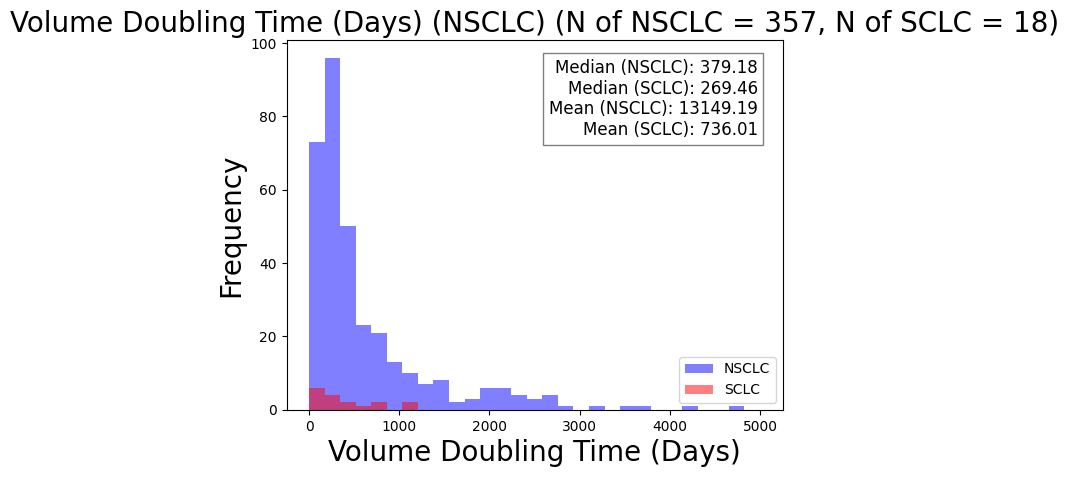

In [233]:
if is_cancer:
    plot_distribution_overlay(growth_df[growth_df["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), growth_df[growth_df["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time (Days) (NSCLC)", "Volume Doubling Time (Days)", "Frequency", "NSCLC", "SCLC", xlim=(0, 5000))

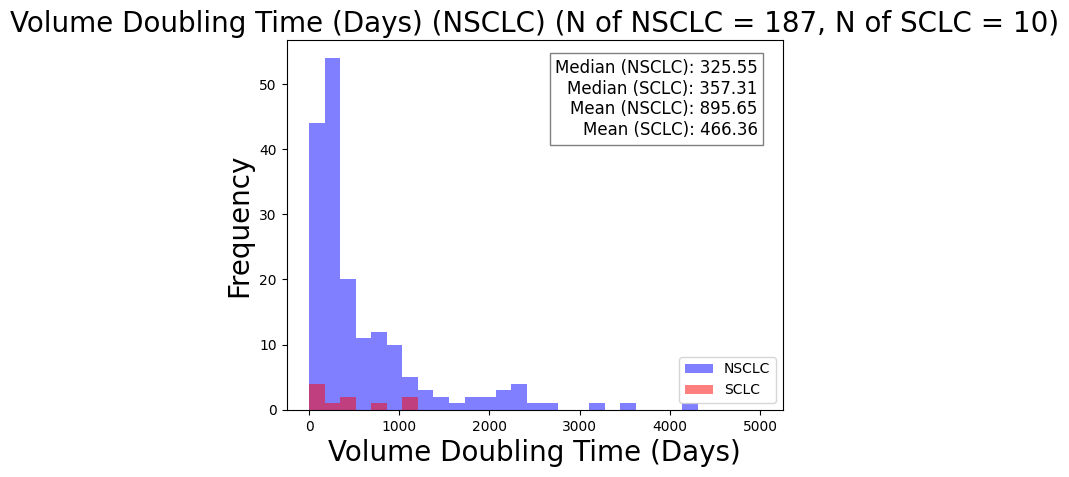

In [234]:
if is_cancer:
    plot_distribution_overlay(growth_df_biggest_only[growth_df_biggest_only["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), growth_df_biggest_only[growth_df_biggest_only["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time (Days) (NSCLC)", "Volume Doubling Time (Days)", "Frequency", "NSCLC", "SCLC", (0, 5000))

In [235]:
print(f"Unmatched Earlier (SCLC): {unmatched_earlier['SCLC']}")
print(f"Unmatched Earlier (NSCLC): {unmatched_earlier['NSCLC']}")
print(f"Unmatched Earlier (Benign): {unmatched_earlier['benign']}")
print("\n")
print(f"Unmatched Later (SCLC): {unmatched_later['SCLC']}")
print(f"Unmatched Later (NSCLC): {unmatched_later['NSCLC']}")
print(f"Unmatched Later (Benign): {unmatched_later['benign']}")

Unmatched Earlier (SCLC): 151
Unmatched Earlier (NSCLC): 1720
Unmatched Earlier (Benign): 0


Unmatched Later (SCLC): 114
Unmatched Later (NSCLC): 1771
Unmatched Later (Benign): 0


## Novel Nodules

How often is there a novel nodule (i.e., an unmatched nodule in T1 and there is a scan for T0, or an unmatched nodule in T2 and there is a scan in T1)?

In [236]:
novel_nodule_data = {}

for pid, pid_entry in data.items():
    has_scan_T0 = "T0" in pid_entry["total_num_nodules"]
    has_scan_T1 = "T1" in pid_entry["total_num_nodules"]

    novel_nodule_data[pid] = {"unmatched_nodules": {}}

    for unmatched_nodule_id, unmatched_nodule_entry in data[pid]["unmatched_nodules"].items():
        if (unmatched_nodule_entry["timepoint"] == "T1" and has_scan_T0) or (unmatched_nodule_entry["timepoint"] == "T2" and (has_scan_T1 or has_scan_T0)):
            novel_nodule_data[pid]["unmatched_nodules"][unmatched_nodule_id] = unmatched_nodule_entry


Over the number of nodules instead of patients

(Go nodule-by-nodule of the unmatched nodules -> does it appear? disappear?)

In [237]:
num_pids_with_at_least_one_novel_nodule = 0

for pid, pid_entry in novel_nodule_data.items():
    if pid_entry["unmatched_nodules"]:
        num_pids_with_at_least_one_novel_nodule += 1

print(f"{num_pids_with_at_least_one_novel_nodule * 100 / len(novel_nodule_data)}% of patients have at least one novel nodule")

56.17367706919946% of patients have at least one novel nodule


## Disappearing Nodules

In [238]:
disappearing_nodule_data = {}

for pid, pid_entry in data.items():
    has_scan_T0 = "T0" in pid_entry["total_num_nodules"]
    has_scan_T1 = "T1" in pid_entry["total_num_nodules"]
    has_scan_T2 = "T2" in pid_entry["total_num_nodules"]

    disappearing_nodule_data[pid] = {"unmatched_nodules": {}}

    for unmatched_nodule_id, unmatched_nodule_entry in data[pid]["unmatched_nodules"].items():
        if (unmatched_nodule_entry["timepoint"] == "T1" and has_scan_T0) or (unmatched_nodule_entry["timepoint"] == "T2" and (has_scan_T1 or has_scan_T0)):
            novel_nodule_data[pid]["unmatched_nodules"][unmatched_nodule_id] = unmatched_nodule_entry


## Early Detection

In [239]:
metadata

,PID,IsSmallCell,CancerTP,NumExams,Days2Cancer_0,DaysSinceRand_0,Annotated_0,Days2FUP_0,Series_0,abnormalities_0,...,change_2,exists_2,slice_number_2,age_2,years_since_quit_smoking_2,age_start_smoking,age_quit_smoking,years_smoking,is_smoker,family_hx
0,104363,False,0.0,1,20.0,57.0,1.2.840.113654.2.55.31289205206602048621229111...,2623.0,['1.2.840.113654.2.55.312892052066020486212291...,[51],...,[],[],[],NaN,NaN,15.0,-1.0,49,1,False
1,126514,False,4.0,3,1744.0,23.0,NaN,2099.0,['1.2.840.113654.2.55.151058074685137500542581...,[51],...,"[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]",69.0,15.0,13.0,54.0,41,0,False
2,215101,False,2.0,2,NaN,NaN,NaN,NaN,[],[],...,"[1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[2.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[124.0, -1.0, -1.0, -1.0, -1.0, -1.0]",71.0,0.0,15.0,-1.0,53,1,False
3,118560,False,2.0,3,924.0,0.0,NaN,2657.0,['1.2.840.113654.2.55.271320444115083086313603...,[65],...,[-1.0],[1.0],[51.0],71.0,8.0,30.0,63.0,33,0,False
4,107791,False,0.0,1,33.0,22.0,1.2.840.113654.2.55.12444939297447887113142959...,2440.0,['1.2.840.113654.2.55.124449392974478871131429...,"[51, 56, 60]",...,[],[],[],NaN,NaN,25.0,66.0,41,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,122025,False,0.0,1,63.0,39.0,1.2.840.113654.2.55.24358410500449861747917111...,531.0,['1.2.840.113654.2.55.243584105004498617479171...,"[51, 51, 65]",...,[],[],[],NaN,NaN,15.0,-1.0,56,1,False
821,216160,False,1.0,2,459.0,0.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.116685732054...,2638.0,['1.3.6.1.4.1.14519.5.2.1.7009.9004.8270077794...,[51],...,[],[],[],NaN,NaN,12.0,-1.0,33,1,True
822,111261,False,4.0,1,1510.0,23.0,NaN,2533.0,['1.2.840.113654.2.55.164498555701873314300047...,"[51, 60, 64, 61, 55]",...,[],[],[],NaN,NaN,17.0,60.0,43,0,False
823,203581,False,2.0,3,836.0,0.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.533941689505...,2462.0,['1.3.6.1.4.1.14519.5.2.1.7009.9004.5339416895...,[],...,"[-1.0, 1.0, -1.0, -1.0]","[1.0, 2.0, -1.0, -1.0]","[63.0, 61.0, -1.0, -1.0]",63.0,0.0,18.0,-1.0,43,1,False


In [240]:
metadata[metadata["PID"] == 116837]["Days2Cancer_1"]

537    493.0
Name: Days2Cancer_1, dtype: float64

In [241]:
def pid_is_annotated(df, pid):
    row = metadata[metadata["PID"] == pid]
    return bool((row["Annotated_0"].notna().values[0]) or (row["Annotated_1"].notna().values[0]) or (row["Annotated_2"].notna().values[0]))

In [242]:
count = 0

data_with_annotations = {}

for pid in data:
    if pid_is_annotated(metadata, int(pid)):
        data_with_annotations[pid] = data[pid]

In [243]:
len(data_with_annotations)

500

In [244]:
compute_basic_statistics(data_with_annotations)

{'num_patients': 500,
 'num_patients_1_scan': 239,
 'num_patients_2_scan': 141,
 'num_patients_3_scan': 120,
 'num_scans': 881,
 'total_predicted_nodules': 3397,
 'unmatched_nodules': 2676,
 'matched_nodules_2': 263,
 'matched_nodules_3': 65,
 'num_patients_with_annotations': 498,
 'num_scans_with_annotations': 815}

## Early Detection with Annotations

In [245]:
numerator = 0
denominator = 0

days_to_cancer_earliest, days_to_cancer_latest = [], []

for pid in data:
    for nodule_idx, nodule_entry in data[pid]["matched_nodules"].items():
        if any([tp_entry["has_bbox_overlap"] for tp, tp_entry in nodule_entry.items() if tp != "T0"]):
            denominator += 1

            row = metadata[metadata["PID"] == int(pid)]

            if "T2" in nodule_entry and nodule_entry["T2"]["has_bbox_overlap"]:
                if "T0" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_0"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_0"].dropna().values[0]))

                elif "T1" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_1"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_1"].dropna().values[0]))
                

                if len(row["Days2Cancer_2"].dropna()) == 1:
                    days_to_cancer_latest.append(int(row["Days2Cancer_2"].dropna().values[0]))
            

            elif "T1" in nodule_entry and nodule_entry["T1"]["has_bbox_overlap"]:
                if "T0" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_0"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_0"].dropna().values[0]))
                
                if len(row["Days2Cancer_1"].dropna()) == 1:
                    days_to_cancer_latest.append(int(row["Days2Cancer_1"].dropna().values[0]))
        

In [246]:
# metadata[["Days2Cancer_0", "Days2Cancer_1", "Days2Cancer_2"]]
metadata["Days2Cancer_1"].isna().value_counts()

Days2Cancer_1
False    533
True     292
Name: count, dtype: int64

In [247]:
print(numerator / denominator) 

1.0


In [248]:
numerator

57

In [249]:
denominator

57

In [250]:
days_to_cancer_earliest

[757,
 457,
 932,
 510,
 560,
 392,
 453,
 411,
 384,
 640,
 497,
 756,
 487,
 402,
 512,
 832,
 417,
 807,
 1059,
 801,
 409,
 484,
 398,
 541,
 503,
 503,
 475,
 494,
 417,
 707,
 488,
 585,
 585,
 763,
 448,
 745,
 849,
 810,
 1061,
 491,
 750,
 863,
 453,
 441,
 438,
 504,
 581,
 476,
 456,
 357,
 482,
 1018,
 445,
 751,
 408,
 408,
 408]

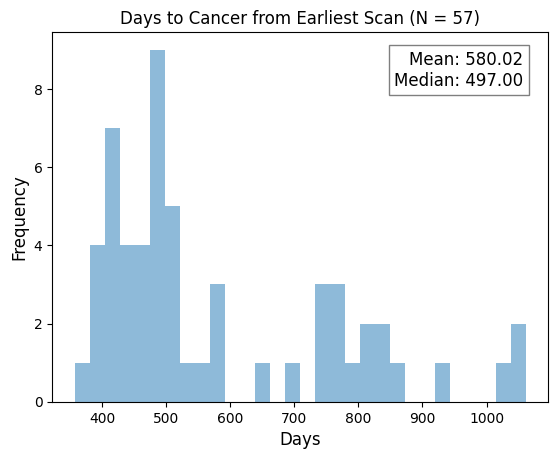

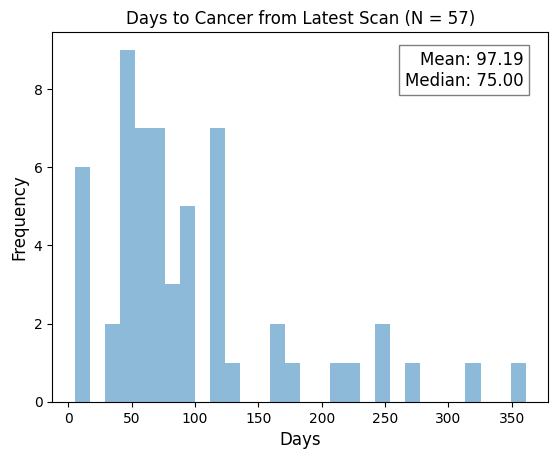

In [251]:
plot_distribution(days_to_cancer_earliest, "Days to Cancer from Earliest Scan", "Days", "Frequency")
plot_distribution(days_to_cancer_latest, "Days to Cancer from Latest Scan", "Days", "Frequency")